Lower Super Output Areas (LSOA) boundaries were obtained from the ONS [here](https://geoportal.statistics.gov.uk/datasets/766da1380a3544c5a7ca9131dfd4acb6/explore). These are clipped (don't extend into the sea etc) and generalised (slightly less detail than the actual boundaries). I downloaded these as geojson since this has a lot of tools that can be worked with, and saved them as a file called `lsoa_boundaries_uk.geojson`.

This is a `61MB` file and we are only really interested in the coastal towns. And we can start with Dover which we can extract and save like this:

```python
import geopandas as gpd

# load the lsoa boundaries
gdf = gpd.read_file('lsoa_boundaries_uk.geojson')

# get the county
gdf['County'] = gdf['LSOA21NM'].str.split(' ', expand=True)[0]

# filter out dover
dover = gdf[gdf['County']=='Dover']

# save
dover.to_file("lsoa_dover.geojson", driver='GeoJSON')
```

This then saves the Dover boundaries in `lsoa_dover.geojson`. We can then take a look at it:

(618886.2086499999, 639040.5043500002, 136671.89950000006, 165514.13049999895)

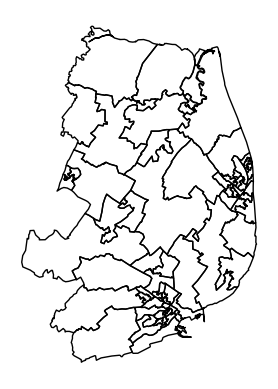

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
dover = gpd.read_file("lsoa_dover.geojson")
fig, ax = plt.subplots()
dover.boundary.plot(ax=ax, linewidth=1, color='black') 
ax.axis('off')
# label areas by county
#thanet_rough.plot()

That's not particularly useful. We can create an interactive map using `folium`

In [2]:
import folium

# centre of the map is going to be the centroid of our dover LSOAs
# (as lat,lon)
dover = dover.to_crs(epsg=4326)
centroid = dover.unary_union.centroid

# Create a map centered at the given coordinates
m = folium.Map(location=[centroid.y,centroid.x], zoom_start=11,height=500)

# Add the data to the map
folium.GeoJson(dover).add_to(m)

# Display the map
display(m)

That's more interesting, we could now take the [rural-urban classification](https://geoportal.statistics.gov.uk/datasets/ons::rural-urban-classification-2011-of-lower-layer-super-output-areas-in-england-and-wales-1) for the LSOAs and overlay that. Assume we've downloaded that and extracted dover again.

In [3]:
import pandas as pd
# load the urban classification
urban_data = pd.read_csv("LSOA_Rural_Urban_Classifications.csv")
# do a left join on our dover data, note ONS has not published 2021 classifications yet
# so the urban column is "LSOA11CD"
dover = dover.merge(urban_data,left_on="LSOA21CD",right_on="LSOA11CD",how="left")
dover.head()


,OBJECTID,LSOA21CD,LSOA21NM,GlobalID,County,geometry,FID,LSOA11CD,LSOA11NM,RUC11CD,RUC11
0,22961,E01024190,Dover 006A,41caa705-3352-43be-83c6-fd0aa7101c70,Dover,"POLYGON ((1.21676 51.23868, 1.21896 51.23700, ...",23550.0,E01024190,Dover 006A,D1,Rural town and fringe
1,22962,E01024192,Dover 006C,c7f643ab-a893-47c6-a9f9-19bf6947161b,Dover,"POLYGON ((1.19373 51.22607, 1.19460 51.22521, ...",23211.0,E01024192,Dover 006C,D1,Rural town and fringe
2,22963,E01024193,Dover 011A,9549816c-fd85-4742-8fa6-baac7d1c3a07,Dover,"POLYGON ((1.30054 51.14350, 1.30060 51.14205, ...",23216.0,E01024193,Dover 011A,C1,Urban city and town
3,22964,E01024194,Dover 011B,6167d889-5c42-426c-b101-8b3718d42b07,Dover,"POLYGON ((1.30357 51.13953, 1.30235 51.13843, ...",23221.0,E01024194,Dover 011B,C1,Urban city and town
4,22965,E01024195,Dover 011C,0a7b4129-d673-4ef6-9267-6158b0a08e6c,Dover,"POLYGON ((1.31655 51.14270, 1.31413 51.14098, ...",23226.0,E01024195,Dover 011C,C1,Urban city and town


Now we want to colour the polygons according to urban classification to get some idea what it looks like:

In [12]:
import json
from ipyleaflet import Map, GeoData, basemaps, LayersControl, LegendControl

# Convert the GeoDataFrame to a GeoJSON object
geo_json_data = json.loads(dover.to_json())

dover_projected = dover.to_crs("EPSG:27700")

# Now calculate the centroid
dover_centroid = dover_projected.geometry.centroid

dover_centroid = dover_centroid.to_crs(dover.crs)
centroid_lat = dover_centroid.y.mean()
centroid_lon = dover_centroid.x.mean()

# Create the map
m = Map(center=(centroid_lat, centroid_lon), zoom=13, basemap=basemaps.OpenStreetMap.Mapnik)



# Create the GeoData layer
geo_data = GeoData(geo_dataframe=dover,
                style={'color': 'black', 'fillColor': '#00000000', 'opacity':0.5, 'weight':1.9,},
                   hover_style={'fillColor': 'red' , 'fillOpacity': 0.2},
                   name='LSOAs')

# Add the layer to the map
m.add_layer(geo_data)

urban_mapping = {
   'Rural village and dispersed' : 1,
   'Rural town and fringe' : 2,
   'Urban city and town' : 3 ,
}

dover['urban_class'] = dover.RUC11.map(urban_mapping)


geo_data_classified = GeoData(
    geo_dataframe = dover,
    style={'color': 'black', 'fillColor': dover.urban_class, 'opacity':0.05, 'weight':1.9, 'dashArray':'2', 'fillOpacity':0.6},
    name='LUC11 Classification'
)

m.add_layer(geo_data_classified)

# Add layer control to the map
m.add_control(LayersControl())

# Define the legend
legend = LegendControl({"Low":"#FAA", "Medium":"#A55", "High":"#500"}, name="Legend", position="bottomright")

# Add the legend to the map
m.add_control(legend)

# Display the map
m


ValueError: Can't clean for JSON: 0     2.0
1     2.0
2     3.0
3     3.0
4     3.0
     ... 
64    3.0
65    NaN
66    NaN
67    NaN
68    NaN
Name: urban_class, Length: 69, dtype: float64

In [6]:
dover_centroid

0     POINT (1.23214 51.22170)
1     POINT (1.19706 51.22322)
2     POINT (1.29821 51.14040)
3     POINT (1.30201 51.13735)
4     POINT (1.30685 51.14226)
                ...           
64    POINT (1.31429 51.12647)
65    POINT (1.37883 51.23942)
66    POINT (1.38681 51.22404)
67    POINT (1.19781 51.23056)
68    POINT (1.20640 51.22982)
Length: 69, dtype: geometry